In [1]:
import gym

from agents.dqn import DQNAgent
from utils.screen import SpaceInvaderScreen
from utils.data_loader import AtariGrandChallengeDataset
from train.solver import Solver

from torch import optim
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray
import numpy as np

%reload_ext autoreload
%autoreload 2

%matplotlib inline

[2018-01-11 15:03:42,543] Making new env: SpaceInvaders-v0


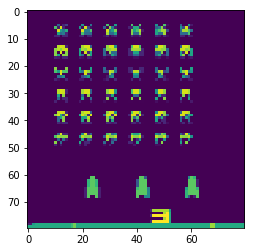

In [2]:
screen = SpaceInvaderScreen()
frame = screen.reset()
plt.imshow(frame);

In [4]:
dataset = AtariGrandChallengeDataset('/mnt/c/data/atari_v2_release', 'spaceinvaders', history_len=10, screen=screen, max_files=2)
data_train, data_valid, data_test = dataset.split(0.7, 0.2)

In [5]:
agent = DQNAgent(screen, mem_size=1000)
agent.initialize(800)

Action: NOOP
Predicted: LEFTFIRE


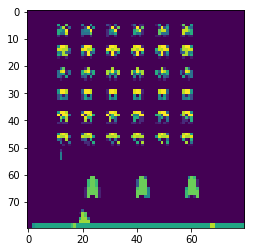

In [15]:
transition = data_train.raw(146) # get as Transition
observation = screen.output(transition.observation)
plt.imshow(observation)
print("Action:", screen.get_action_meaning(transition.action))
print("Predicted:", screen.get_action_meaning(agent.next_action(observation)))

In [16]:
batchsize = 10

train_loader = DataLoader(data_train, batch_size=batchsize, num_workers=4)
val_loader = DataLoader(data_valid, batch_size=batchsize, num_workers=4)

In [ ]:
solver = Solver(optim.Adam, CrossEntropyLoss(), batchsize)
solver.train_offline(agent, train_loader, val_loader, num_epochs=1, log_nth=0)


In [ ]:
print(solver.loss_history)